Importing libraries

In [1]:
!echo !pip install matplotlib

!pip install matplotlib


In [3]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time

### Creating data parser

In [4]:
DATABASE_URL = "https://crossoutdb.com/"

def getJSONDataOfItemByID(fileID: int):
    id = fileID
    path = 'data/item/all/'
    url = DATABASE_URL + path + str(id)
    requests_file = requests.get(url)
    jsonData = requests_file.json()['Data']
    return jsonData

JSONdataOfItemWithID_68 = getJSONDataOfItemByID(68)
JSONdataOfItemWithID_60 = getJSONDataOfItemByID(60)
JSONdataOfItemWithID_7 = getJSONDataOfItemByID(7)

In [5]:
def convertOneItemDataToDataframeFromJson(jsonData):
    jsonDataCopy_1 = jsonData
    
    def getArrayDataFromJson(jsonData):
        jsonDataCopy = jsonData
        
        numberOfColumns = len(jsonDataCopy)
        numberOfRows = len(jsonDataCopy[0])

        # json file has shape of 4 "columns" with the same lenght. 
        # Each column is represented by time (like key) and its value.

        arrayData = []
        for row in range(numberOfRows):
            sellPrice = jsonDataCopy[0][row][1]
            buyPrice = jsonDataCopy[1][row][1]
            sellOffers = jsonDataCopy[2][row][1]
            buyOrders = jsonDataCopy[3][row][1]

            # key / time --- UNIX_TIMESTAMP
            dateTime = jsonDataCopy[0][row][0]

            rowData = [dateTime, sellPrice, buyPrice, sellOffers, buyOrders]
            arrayData.append(rowData)
        return arrayData
    
    numpyArrayData = np.array(getArrayDataFromJson(jsonDataCopy_1))
    df = pd.DataFrame(numpyArrayData, columns=["Date Time", "Sell Price", "Buy Price", "Sell Offers", "Buy Orders"])
    return df

In [6]:
data_df = convertOneItemDataToDataframeFromJson(JSONdataOfItemWithID_7)
print(data_df.head())

      Date Time  Sell Price  Buy Price  Sell Offers  Buy Orders
0  1.711134e+12       38.39      33.71         39.0        93.0
1  1.711138e+12       38.91      33.21         45.0        81.0
2  1.711141e+12       38.79      32.22         43.0        78.0
3  1.711145e+12       38.99      32.21         39.0        75.0
4  1.711148e+12       39.48      32.21         32.0        72.0


## Creating plot form data

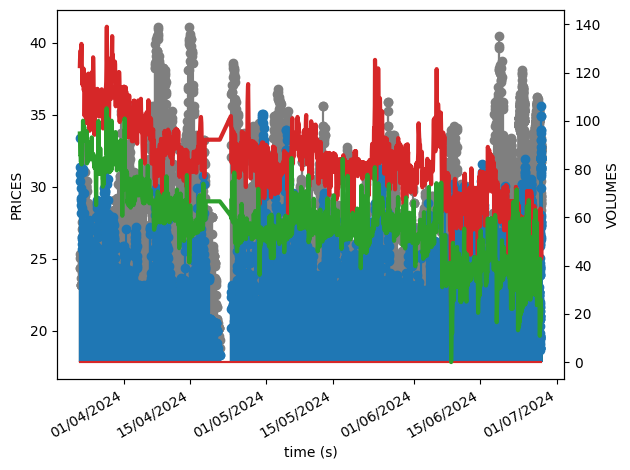

In [7]:
import matplotlib.dates as mdates

def plotData(data: pd.core.frame.DataFrame):
    dateTime = data["Date Time"]
    sellPrice = data["Sell Price"]
    buyPrice = data["Buy Price"]
    sellOffers = data["Sell Offers"]
    buyOrders = data["Buy Orders"]
    
    def formatData(data):
        floatData = data.apply(lambda x: float(x))
        dataArray = floatData.to_numpy()
        return dataArray
    
    dateTime = pd.to_datetime(dateTime, unit='ms')
    sellPrice = formatData(sellPrice)
    buyPrice = formatData(buyPrice)
    sellOffers = formatData(sellOffers)
    buyOrders = formatData(buyOrders)
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('PRICES')
    ax1.plot(dateTime, sellPrice, color='tab:red', linewidth=3)
    ax1.plot(dateTime, buyPrice, color='tab:green', linewidth=3)
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('VOLUMES')  # we already handled the x-label with ax1
    ax2.stem(dateTime, sellOffers, linefmt='tab:grey')
    ax2.stem(dateTime, buyOrders, linefmt='tab:blue')
    ax2.tick_params(axis='y')
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    fig.autofmt_xdate()  # Rotation of date labels

    ax1.set_zorder(2)
    ax2.set_zorder(1)
    ax1.patch.set_visible(False)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
plotData(data_df)

#### Market history is too large. We will operrate on last week history. So lets create a trim function

In [8]:
from datetime import timedelta

def trimDataFromTheLastWeek(data: pd.core.frame.DataFrame):
    WEEK_SECONDS = 604800
    
    dataCopy = data.copy()
    
    dataCopy['Temp Date Time'] = pd.to_datetime(dataCopy['Date Time'], unit='ms')

    lastTimestamp = dataCopy['Temp Date Time'].iloc[-1]
    
    oneWeekAgo = lastTimestamp  - timedelta(weeks=1)
    
    dfLastWeek = dataCopy[dataCopy['Temp Date Time'] >= oneWeekAgo]
    
    dfLastWeek.reset_index(drop=True, inplace=True)
    
    dfLastWeek = dfLastWeek.drop(columns=['Temp Date Time'])
    
    return dfLastWeek

lastWeekData = trimDataFromTheLastWeek(data_df)
print(lastWeekData)

         Date Time  Sell Price  Buy Price  Sell Offers  Buy Orders
0     1.718909e+12       27.74      24.00         70.0        29.0
1     1.718910e+12       27.74      24.00         70.0        29.0
2     1.718910e+12       27.74      24.00         69.0        29.0
3     1.718910e+12       27.70      24.00         69.0        37.0
4     1.718911e+12       27.70      24.00         69.0        37.0
...            ...         ...        ...          ...         ...
1934  1.719513e+12       28.06      21.30         89.0        96.0
1935  1.719513e+12       28.05      21.33         89.0        95.0
1936  1.719513e+12       25.25      21.45         92.0       106.0
1937  1.719514e+12       25.25      21.45         91.0       102.0
1938  1.719514e+12       25.25      21.46         90.0       102.0

[1939 rows x 5 columns]


## Now we can look at plot

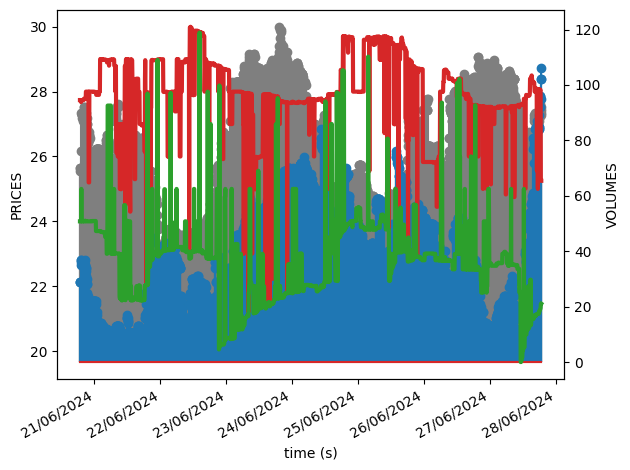

In [142]:
plotData(lastWeekData)

# Let's start do some neural networking

1) сделать цену в будующем +(классифицировать на покупать/не покупать)
2) разделить на validation и train
3) сделать sequantial data определенно длинны (например хочу предиктеть данные через 10 минут (2 строчки) используя предыдущие 50 минут (10 строчек) )
4) сбалансировать данные
5) нормализировать
6) сделать модель

1)посмотреть где можно сдлелать inplace=True
2)именнование переменных
3)сделать код чищье

In [143]:
main_df = lastWeekData.copy()
main_df.set_index("Date Time", inplace = True)
print(main_df)

              Sell Price  Buy Price  Sell Offers  Buy Orders
Date Time                                                   
1.718909e+12       27.74      24.00         70.0        29.0
1.718910e+12       27.74      24.00         70.0        29.0
1.718910e+12       27.74      24.00         69.0        29.0
1.718910e+12       27.70      24.00         69.0        37.0
1.718911e+12       27.70      24.00         69.0        37.0
...                  ...        ...          ...         ...
1.719513e+12       28.06      21.30         89.0        96.0
1.719513e+12       28.05      21.33         89.0        95.0
1.719513e+12       25.25      21.45         92.0       106.0
1.719514e+12       25.25      21.45         91.0       102.0
1.719514e+12       25.25      21.46         90.0       102.0

[1939 rows x 4 columns]


In [144]:
SEQ_LEN = 10
FUTURE_PERIOD_PREDICT = 2

def classifyBySellPrice(current, future):
    if float(future) >= float(current):
        return 1
    else:
        return 0

In [145]:
main_df['future Sell Price'] = main_df["Sell Price"].shift(-FUTURE_PERIOD_PREDICT)
print(main_df.head())

              Sell Price  Buy Price  Sell Offers  Buy Orders  \
Date Time                                                      
1.718909e+12       27.74       24.0         70.0        29.0   
1.718910e+12       27.74       24.0         70.0        29.0   
1.718910e+12       27.74       24.0         69.0        29.0   
1.718910e+12       27.70       24.0         69.0        37.0   
1.718911e+12       27.70       24.0         69.0        37.0   

              future Sell Price  
Date Time                        
1.718909e+12              27.74  
1.718910e+12              27.70  
1.718910e+12              27.70  
1.718910e+12              27.68  
1.718911e+12              27.70  


In [146]:
main_df['target'] = list(map(classifyBySellPrice, main_df["Sell Price"], main_df["future Sell Price"]))
print(main_df.head())

              Sell Price  Buy Price  Sell Offers  Buy Orders  \
Date Time                                                      
1.718909e+12       27.74       24.0         70.0        29.0   
1.718910e+12       27.74       24.0         70.0        29.0   
1.718910e+12       27.74       24.0         69.0        29.0   
1.718910e+12       27.70       24.0         69.0        37.0   
1.718911e+12       27.70       24.0         69.0        37.0   

              future Sell Price  target  
Date Time                                
1.718909e+12              27.74       1  
1.718910e+12              27.70       0  
1.718910e+12              27.70       0  
1.718910e+12              27.68       0  
1.718911e+12              27.70       1  


In [147]:
times = sorted(main_df.index.values)
last_5pct_index = int(0.05*len(times))
print(last_5pct_index)

last_5pct = times[-last_5pct_index]
print(last_5pct)

96
1719484800000.0


In [148]:
validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]

In [156]:
from sklearn import preprocessing
from collections import deque
import random

def preprocess_df(df):
    df = df.drop('future Sell Price', axis=1)
    
    for col in df.columns:
        if col != 'target':
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    
    df.dropna(inplace=True)
    
    sequencial_data = []
    prev_days = deque(maxlen=SEQ_LEN)
    
    for i in df.values:                          #here we lose date time
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequencial_data.append([np.array(prev_days), i[-1]])
    
    random.shuffle(sequencial_data)
    
    
    
    we_buy_this = []
    we_do_not_buy_this = []
    
    for seq, target in sequencial_data:
        if target == 0:
            we_do_not_buy_this.append([seq, target])
        elif target == 1:
            we_buy_this.append([seq, target])
    
    lower = min(len(we_buy_this), len(we_do_not_buy_this))
    
    we_buy_this = we_buy_this[:lower];
    we_do_not_buy_this = we_do_not_buy_this[:lower]
    
    sequencial_data = we_buy_this + we_do_not_buy_this
    random.shuffle(sequencial_data)
    
    X = []
    y = []
    
    for seq, target in sequencial_data:
        X.append(seq)
        y.append(target)
        
    return np.array(X), y
        

train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

print(len(train_x))
print(train_x.shapeape)

1026
(1026, 10, 4)
